In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import yaml
import numpy as np
from tensorflow.keras.utils import to_categorical

In [6]:
file = open("settings2.yaml")
settings = yaml.load(file,Loader=yaml.BaseLoader)
print(settings)
rawTrainingDataPath = settings.get("BraTS2020").get("TrainingDataPath")
preTrainingDataPath = settings.get("BraTS2020").get("PreprocessedDataPath")

{'BraTS2020': {'TrainingDataPath': '/home/luxiwen/Datasets/BraTS2020/MICCAI_BraTS2020_TrainingData/', 'PreprocessedDataPath': '/home/luxiwen/Datasets/BraTS2020/preTrain', 'SplitDataPath': '/home/luxiwen/Datasets/BraTS2020/input_data_128'}}


In [6]:
# n.zfill(3) to create a num with 3 digit

test_one = "BraTS20_Training_001"
test_nii = os.path.join(rawTrainingDataPath,test_one,test_one+"_flair.nii.gz")
test_img_flair = nib.load(test_nii).get_fdata()
print(test_img_flair.max())

625.0


In [7]:
# scaler the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

test_image_flair = scaler.fit_transform(test_img_flair.reshape(-1,test_img_flair.shape[-1])).reshape(test_img_flair.shape)
print(test_image_flair.max())

1.0


In [8]:

test_image_t1 = nib.load(os.path.join(rawTrainingDataPath,test_one,test_one+'_t1.nii.gz')).get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = nib.load(os.path.join(rawTrainingDataPath,test_one,test_one+'_t1ce.nii.gz')).get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(
    test_image_t1ce.shape)

test_image_t2 = nib.load(os.path.join(rawTrainingDataPath,test_one,test_one+'_t2.nii.gz')).get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask = nib.load(os.path.join(rawTrainingDataPath,test_one,test_one+'_seg.nii.gz')).get_fdata()
test_mask = test_mask.astype(np.uint8)

print(np.unique(test_mask)) 

[0 1 2 4]


In [9]:
test_mask[test_mask == 4] = 3  # Reassign mask values 4 to 3
print(np.unique(test_mask))


[0 1 2 3]


In [14]:
def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row, col = image.shape
        mean = 0
        var = 0.1
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row, col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
        out[tuple(coords)] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
        out[tuple(coords)] = 0
        return out

    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        row, col = image.shape
        gauss = np.random.randn(row, col )
        gauss = gauss.reshape(row, col )
        noisy = image + image * gauss
        return noisy

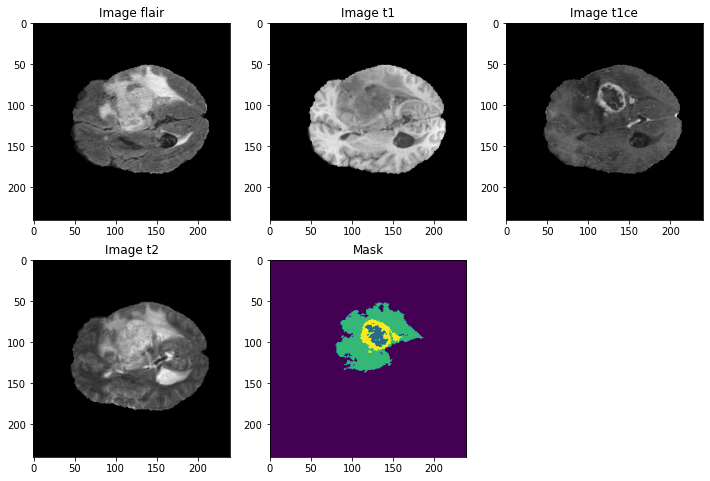

In [21]:
import random

n_slice = random.randint(0, test_mask.shape[2])

def show_one_slice_raw(n_slice:int):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.imshow(test_image_flair[:, :, n_slice], cmap='gray')
    plt.title('Image flair')
    plt.subplot(232)
    plt.imshow(test_image_t1[:, :, n_slice], cmap='gray')
    plt.title('Image t1')
    plt.subplot(233)
    plt.imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
    plt.title('Image t1ce')
    plt.subplot(234)
    plt.imshow(test_image_t2[:, :, n_slice], cmap='gray')
    plt.title('Image t2')
    plt.subplot(235)
    plt.imshow(test_mask[:, :, n_slice])
    plt.title('Mask')
    plt.savefig('./image/origindata_{}'.format(n_slice),dpi=600)
    plt.show()

show_one_slice_raw(n_slice)

In [11]:
# Flair, T1CE, annd T2 have the most information
# Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

# Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
# cropping x, y, and z
# combined_x=combined_x[24:216, 24:216, 13:141]

combined_x = combined_x[56:184, 56:184, 13:141]  # Crop to 128x128x128x4

# Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]


In [12]:
n_slice = 58

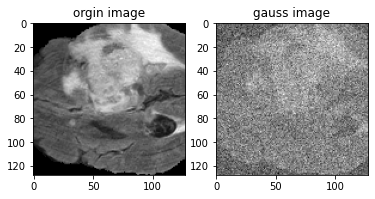

/tmp/ipykernel_63245/490044594.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/tmp/ipykernel_63245/490044594.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


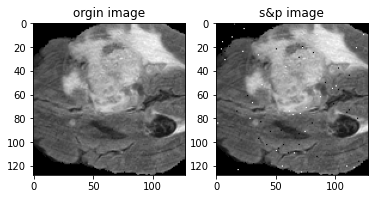

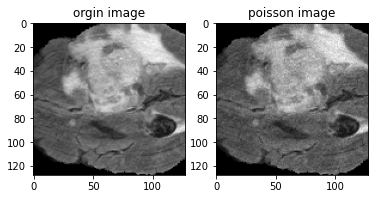

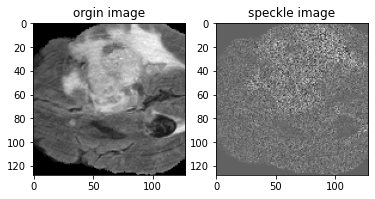

In [21]:
def addNoise(mode:str):
    plt.subplot(121)
    plt.imshow(combined_x[:,:,n_slice,0],cmap='gray')
    plt.title("orgin image")
    plt.subplot(122)
    plt.imshow(noisy(mode,combined_x[:,:,n_slice,0]),cmap='gray')
    plt.title("{} image".format(mode))
    plt.savefig('./image/noise_{}_{}'.format(mode,n_slice),dpi=600)
    plt.show()

addNoise('gauss')
addNoise('s&p')
addNoise('poisson')
addNoise('speckle')

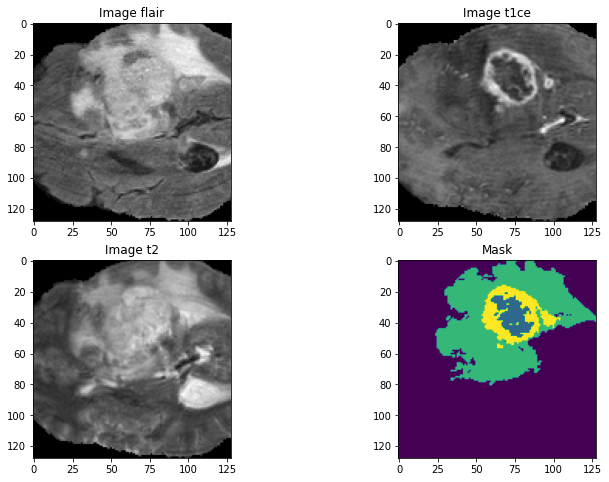

In [25]:
n_slice = random.randint(0, test_mask.shape[2])
def show_one_slice(n_slice:int):
    plt.figure(figsize=(12, 8))

    plt.subplot(221)
    plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
    plt.title('Image flair')
    plt.subplot(222)
    plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
    plt.title('Image t1ce')
    plt.subplot(223)
    plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
    plt.title('Image t2')
    plt.subplot(224)
    plt.imshow(test_mask[:, :, n_slice])
    plt.title('Mask')
    plt.savefig('./image/predata_{}'.format(n_slice),dpi=600)

    plt.show()
show_one_slice(n_slice)

In [25]:
a = os.path.join(rawTrainingDataPath,'testnpy.npy')
np.save(a, combined_x)

In [ ]:
b = np.load(a)
b.shape

In [39]:
import torch
# # convert to the one-hot labels
# test_mask = to_categorical(test_mask, num_classes=4)
# converts an array into a one hot vector.
# Source: https://stackoverflow.com/questions/36960320/convert-a-2d-matrix-to-a-3d-one-hot-matrix-numpy
def one_hot(data:np.ndarray, ncols=4):
    shape = data.shape
    data = data.ravel()
    out = np.zeros((len(data),ncols))
    for i in range(len(data)):
        out[i,data[i]]=1

    return out.reshape((shape[0],shape[1],shape[2],ncols))

test_mask_onehot = one_hot(test_mask,ncols=4)

In [3]:
import glob
# process the whole dataset
t2_list = sorted(glob.glob(os.path.join(rawTrainingDataPath,'*','*t2.nii.gz')))
t1ce_list = sorted(glob.glob(os.path.join(rawTrainingDataPath,'*','*t1ce.nii.gz')))
flair_list = sorted(glob.glob(os.path.join(rawTrainingDataPath,'*','*flair.nii.gz')))
mask_list = sorted(glob.glob(os.path.join(rawTrainingDataPath,'*','*seg.nii.gz')))

In [5]:
for img in range(len(t2_list)):  # Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    # temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    # temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(
    #     temp_image_t2.shape)
    #
    # temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    # temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(
    #     temp_image_t1ce.shape)
    #
    # temp_image_flair = nib.load(flair_list[img]).get_fdata()
    # temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(
    #     temp_image_flair.shape)

    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values 4 to 3
    # print(np.unique(temp_mask))

    # temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    # cropping x, y, and z
    # temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0] / counts.sum())) > 0.01:  # At least 1% useful volume with labels that are not 0
        print("Save {} successful.".format(img))
        # temp_mask = one_hot(temp_mask, ncols=4)
        temp_mask = to_categorical(temp_mask,num_classes=4)
        # np.save(os.path.join(preTrainingDataPath,'images','image_'+str(img)+'.npy'),temp_combined_images)
        np.save(os.path.join(preTrainingDataPath,'masks','mask_'+str(img)+'.npy'),temp_mask)

    else:
        print("Pass {}.".format(img))

Now preparing image and masks number:  0
Save 0 successful.
Now preparing image and masks number:  1
Save 1 successful.
Now preparing image and masks number:  2
Save 2 successful.
Now preparing image and masks number:  3
Save 3 successful.
Now preparing image and masks number:  4
Pass 4.
Now preparing image and masks number:  5
Save 5 successful.
Now preparing image and masks number:  6
Save 6 successful.
Now preparing image and masks number:  7
Save 7 successful.
Now preparing image and masks number:  8
Save 8 successful.
Now preparing image and masks number:  9
Save 9 successful.
Now preparing image and masks number:  10
Save 10 successful.
Now preparing image and masks number:  11
Save 11 successful.
Now preparing image and masks number:  12
Save 12 successful.
Now preparing image and masks number:  13
Save 13 successful.
Now preparing image and masks number:  14
Save 14 successful.
Now preparing image and masks number:  15
Save 15 successful.
Now preparing image and masks number:  

In [7]:
import splitfolders
inputdata = preTrainingDataPath
outputdata = settings.get("BraTS2020").get("SplitDataPath")

In [8]:
splitfolders.ratio(inputdata,output=outputdata,seed=42,ratio=(.75,.25),group_prefix=None)


In [4]:
b.min()

0.0